# Peak fitting for XRD pattern from dpp

- Please check [setup_for_notebooks](./setup_for_notebooks.ipynb) file if you have problem using the notebooks in this folder.

## Check the versio of pyFAI in your conda environment

In [1]:
import pyFAI
pyFAI.version

/Users/DanShim/anaconda/envs/peakpo7721/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'0.14.2'

Note that the example data files I provided are made with `pyFAI` version `0.14`.  If you see version higher than `0.15` here, you will get error when you read the example `dpp` file.  In that case, you either follow the instruction in [setup_for_notebooks.ipynb](./setup_for_notebooks.ipynb) or you may use your own dpp for this note book.

## Read dpp

In [2]:
import dill
import numpy as np

In [3]:
%ls ./data/*.dpp

./data/hSiO2_404_009.dpp


In [5]:
filen_dpp = './data/hSiO2_404_009.dpp'

In [6]:
with open(filen_dpp, 'rb') as f:
    model_dpp = dill.load(f)

## Setup a new PeakPo model and assign info from dpp

In [7]:
from model import PeakPoModel
model = PeakPoModel()

Make sure to reset the chi folder location using the `new_chi_path` option.

In [8]:
model.set_from(model_dpp, new_chi_path='./data/')

See `xrd_pattern.ipynb` file for basic operations.

## Make a simple plot

In [9]:
def dsp2tth(dsp, wavelength):
    return np.rad2deg( np.arcsin( wavelength / (2. * dsp) ) ) * 2.

def tth2dsp(tth, wavelength):
    return 0.5 * wavelength / np.sin( np.deg2rad(tth/2.) )

In [10]:
def plot_diffpattern(ax_pattern, model, xrange=None, yrange=None, bgsub=True,
                    no_yticks=True, dsp_ticks=False, dsp_step = 0.2):
    """
    ax_pattern = axis of diffraction pattern
    model = PeakPo model
    
    """
    wavelength = model.base_ptn.wavelength
    ax_pattern.set_ylabel('Intensity (arbitrary unit)')

    if no_yticks:
        ax_pattern.set_yticks([])
    if bgsub:
        x_data, y_data = model.base_ptn.get_bgsub()
    else:
        x_data, y_data = model.base_ptn.get_raw()
        
    if dsp_ticks and (xrange is not None):
        xrange[0] = dsp2tth(xrange[0], wavelength)
        xrange[1] = dsp2tth(xrange[1], wavelength)        
    
    if xrange is None:
        xrange = [x_data.min(), x_data.max()]
    if yrange is None:
        yrange = [y_data.min(), y_data.max()]
    x = np.ma.masked_where( (x_data <= xrange[0]) | (x_data >= xrange[1]), x_data )
    y = np.ma.masked_where( (x_data <= xrange[0]) | (x_data >= xrange[1]), y_data )
    ax_pattern.set_xlim(xrange)    
    ax_pattern.set_ylim(yrange)        
    ax_pattern.plot(x, y, c='k', lw=1.0)

    #if xrange is not None:
    #    ax_pattern.set_xlim(x.min(),x.max())

    if dsp_ticks:
        ticks = np.arange( np.floor( (dsp2tth(x, wavelength)*10.).max())/10.,
                          np.ceil( (dsp2tth(x, wavelength)*10.).min())/10.,-dsp_step)
        ticks_in_tth = dsp2tth(ticks, wavelength)
        ax_pattern.set_xticks(ticks_in_tth)
        ax_pattern.set_xticklabels(np.around(ticks, decimals=2))
        ax_pattern.set_xlabel('d-spacing ($\mathdefault{\AA}$)')
    else:
        ax_pattern.set_xlabel('Two Theta (degrees)')

In [11]:
def plot_jcpds(ax_pattern, model, 
               in_cake=False,
               show_index=False, show_legend=False,
               bar_height=1., bar_position=0., bar_vsep=0.,
              phase_names=None):
    """
    bar position: position of the bar base in fraction.  negative number will shift 
        bars further down
    """
    selected_phases = []
    for phase in model.jcpds_lst:
        if phase.display:
            selected_phases.append(phase)
    if phase_names is not None:
        if len(phase_names) != len(selected_phases):
            return
    else:
        phase_names = []
        for phase in selected_phases:
            phase_names.append(phase.name) 
            
    n_displayed_jcpds = len(selected_phases)
    axisrange = ax_pattern.axis()
    #bar_scale = 1. / 100. * axisrange[3] * bar_factor / 100.
    pressure = model.get_saved_pressure()
    temperature = model.get_saved_temperature()
    wavelength =  model.base_ptn.wavelength
    for i, phase in enumerate(selected_phases):
        phase.cal_dsp(pressure, temperature)
        tth, inten = phase.get_tthVSint(wavelength)
        intensity = inten * phase.twk_int
        starting_intensity = np.ones_like(tth) * axisrange[2] - \
            bar_position * (axisrange[3] - axisrange[2])
        bar_max = starting_intensity - \
            (i*bar_vsep) * 100. * (bar_height) / n_displayed_jcpds
        bar_min = starting_intensity - \
            (i*bar_vsep+1) * 100. * (bar_height) / n_displayed_jcpds
        if pressure == 0.:
            volume = phase.v
        else:
            volume = phase.v.item()
        ax_pattern.vlines(
            tth, bar_min, bar_max, colors=phase.color,
            label=phase_names[i],
            lw=1.0,
            alpha=1.0)
        # hkl
        if show_index:
            hkl_list = phase.get_hkl_in_text()
            for j, hkl in enumerate(hkl_list):
                if tth[j] >= axisrange[0] and tth[j] <= axisrange[1]:
                    ax_pattern.text(
                        tth[j], bar_max[j], hkl.replace(" ", ""), color=phase.color,
                        rotation=90, verticalalignment='bottom',
                        horizontalalignment='center',
                        fontsize=8.,
                        alpha=1.0)
        ax_pattern.text(
            axisrange[0] + (axisrange[1] - axisrange[0])*0.01, 
            (bar_max[0] + bar_min[0])/2., phase_names[i],
            color=phase.color,
            verticalalignment='center',
            horizontalalignment='left',
            fontsize=8.,
            alpha=1.0)
    ymin = axisrange[2] - bar_position * (axisrange[3] - axisrange[2]) - \
        ( (n_displayed_jcpds-1) * bar_vsep + 1) * 100. * bar_height / n_displayed_jcpds
    ax_pattern.set_ylim((ymin, axisrange[3]))

    if show_legend:
        leg_jcpds = ax_pattern.legend(
            loc=0, prop={'size': 10}, framealpha=0., handlelength=1)
        for line, txt in zip(leg_jcpds.get_lines(), leg_jcpds.get_texts()):
            txt.set_color(line.get_color())

(6.0005517, 20.994111, -49.29726309993839, 2799.9014723947457)
(6.0005517, 20.994111, -2334.2171366494067, 2799.9014723947457)


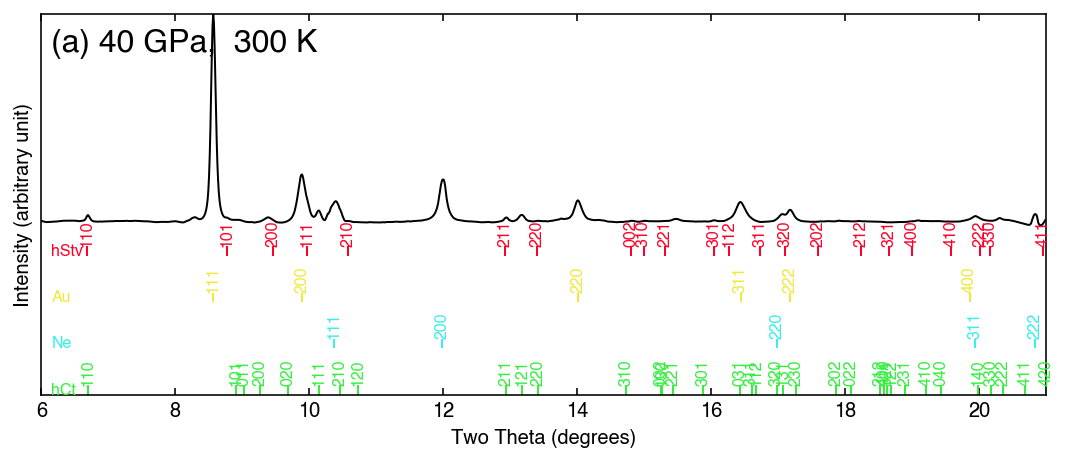

In [12]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

f, ax = plt.subplots(figsize=(9,3.5))
plot_diffpattern(ax, model)
print(ax.axis())
plot_jcpds(ax, model, bar_position=0.1, bar_height=5, 
           show_index=True, 
           phase_names = ['hStv', 'Au', 'Ne', 'hCt'], bar_vsep=5.)
print(ax.axis())
pressure = model.get_saved_pressure()
temperature = model.get_saved_temperature()
ax.text(0.01,0.9, "(a) {0:.0f} GPa, {1: .0f} K".format(pressure, temperature), 
        transform = ax.transAxes, fontsize=16)
plt.savefig('test.pdf', bbox_inches='tight')

## Choose ROI

Check by changing the `xrange` for `plot_diffpattern`.

(6.0, 11.0, -49.29726309993839, 2799.9014723947457)
(6.0, 11.0, -2334.2171366494067, 2799.9014723947457)


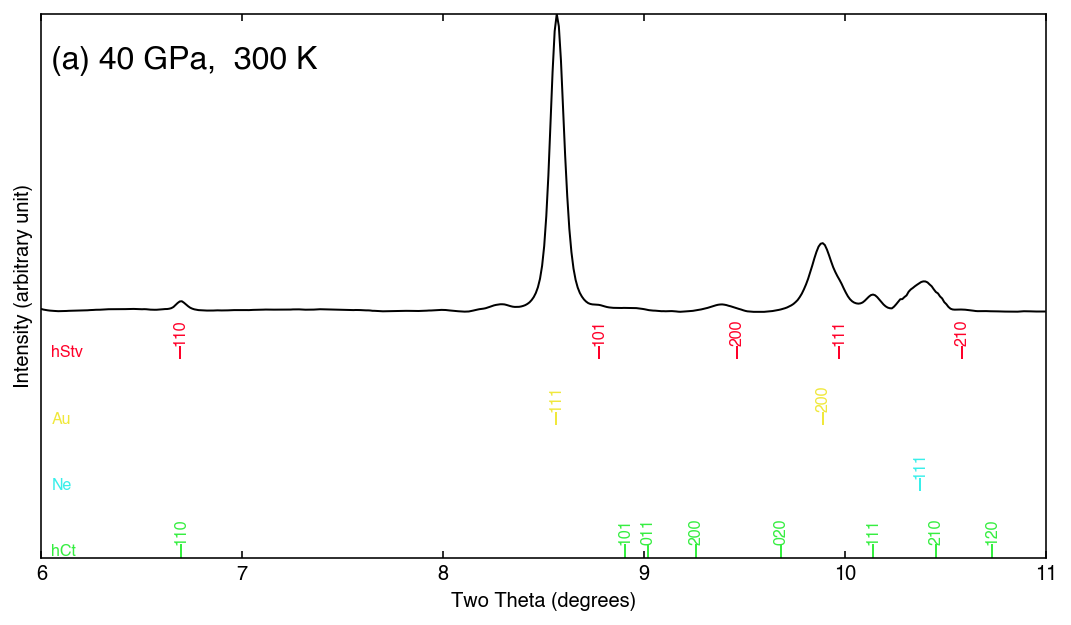

In [13]:
f, ax = plt.subplots(figsize=(9,5))
plot_diffpattern(ax, model, xrange=[6, 11])
print(ax.axis())
plot_jcpds(ax, model, bar_position=0.1, bar_height=5, 
           show_index=True, 
           phase_names = ['hStv', 'Au', 'Ne', 'hCt'], bar_vsep=5.)
print(ax.axis())
pressure = model.get_saved_pressure()
temperature = model.get_saved_temperature()
ax.text(0.01,0.9, "(a) {0:.0f} GPa, {1: .0f} K".format(pressure, temperature), 
        transform = ax.transAxes, fontsize=16)
plt.savefig('test.pdf', bbox_inches='tight')

Get background subtracted pattern for masking.

In [14]:
x, y = model.base_ptn.get_bgsub()

Masking for ROI

In [15]:
import numpy.ma as ma

x_ma = ma.masked_outside(x, 6., 11.)
y_ma = ma.masked_where(np.ma.getmask(x_ma), y)

Quick plot to check

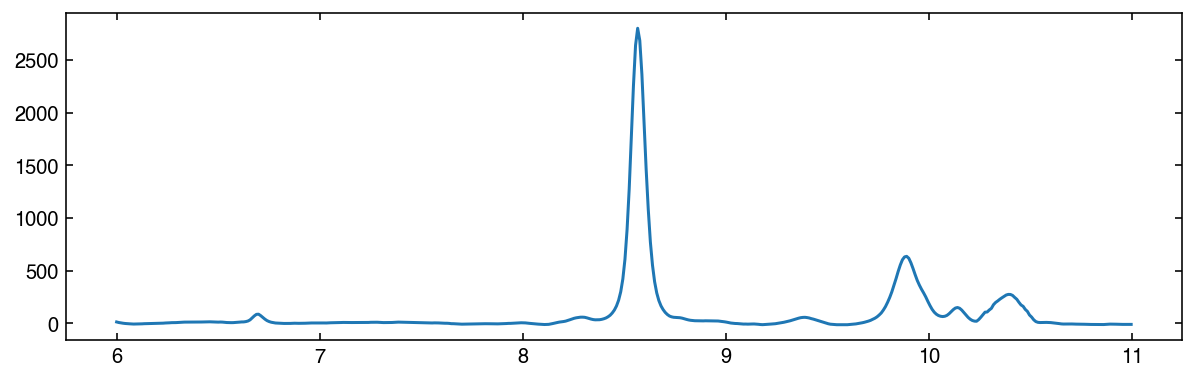

In [16]:
figure = plt.subplots(figsize=(10,3))
plt.plot(x_ma, y_ma)

## Setup fitting model

In [17]:
from lmfit.models import PseudoVoigtModel, LinearModel
from lmfit import Parameters

## Make initial peak position array

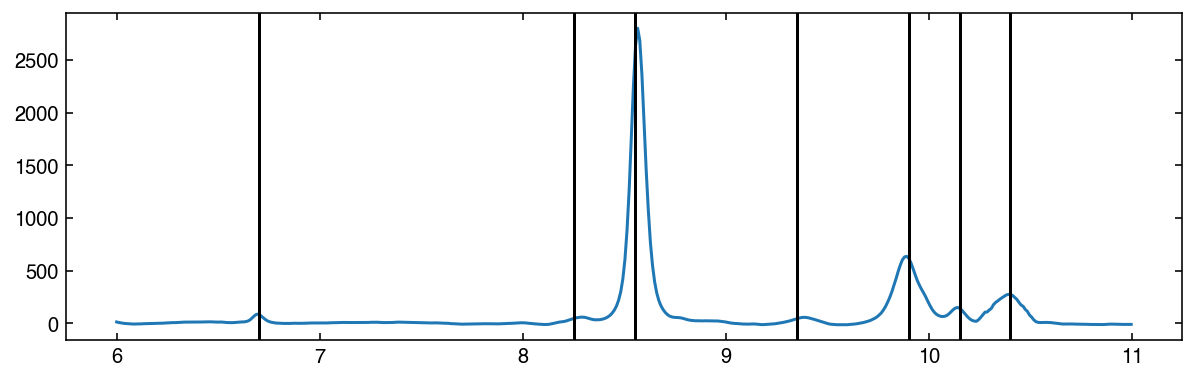

In [18]:
peak_positions_i = [6.7, 8.25, 8.55, 9.35, 9.9, 10.15, 10.4]

figure = plt.subplots(figsize=(10,3))
plt.plot(x_ma, y_ma)
for pkpo in peak_positions_i:
    plt.axvline(pkpo, c='k')

Define functions for peakfitting

In [19]:
def make_model(peak_positions, fwhm=0.05, max_fwhm=0.5, pos_range=0.5, amplitude=1000.):
    n_peaks = len(peak_positions)
    pars = Parameters()

    bg = LinearModel(prefix='bg_')
    pars.update(bg.make_params(slope=0, intercept=0))
    
    mod = bg
    #pars['bg_intercept'].set(vary=True)
    #pars['bg_slope'].set(vary=True)

    for i in range(n_peaks):
        prefix = 'pk{}_'.format(i)
        peak = PseudoVoigtModel(prefix= prefix)
        # Set this zero
        pars.update( peak.make_params())
        pars[prefix+'center'].set(peak_positions[i], min=peak_positions[i]-pos_range, 
                                  max=peak_positions[i]+pos_range, vary=True)
        pars[prefix+'sigma'].set(fwhm, min=0., max=max_fwhm, vary=True)
        pars[prefix+'amplitude'].set(amplitude, min=0., vary=True)
        pars[prefix+'fraction'].set(0.0, min=0., max=1., vary=True)
        mod += peak
    return mod, pars

In [20]:
def plot_fitresult(ax, x, y, out, n_peaks):
    #plt.title(data_filename)
    comps = out.eval_components(x=x)
    ax.plot(x, y, 'k.', label='data')
    #plt.plot(spr_x, init, 'k--')
    ax.plot(x, out.best_fit, 'b-', label='total fit')
    #plt.plot(x, comps['pk_water_'], 'b-', label='indiv. peak')
    #plt.plot(x, comps['pk1_']+comps['pk2_']+comps['pk3_']+comps['pk4_'], 'g-', label='No H2O')
    #plt.plot(spr_x_fit, comps['bg_'], 'b-', label='background')
    ax.plot(x, y - out.best_fit - y.max()*0.2, 'g-', label='fit residue')

    for i in range(n_peaks):
        prefix = 'pk{}_'.format(i)
        ax.axvline(out.params[prefix+'center']) 
        ax.plot(x, comps[prefix] - y.max()*0.1, 'r-', label='indiv. peak')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## First fitting attempt without any restriction

In [21]:
mod, pars = make_model(peak_positions_i)
out = mod.fit(y_ma, pars, x=x_ma, fit_kws={'maxfev': 500})
print(out.fit_report(min_correl=0.5))

[[Model]]
    (((((((Model(linear, prefix='bg_') + Model(pvoigt, prefix='pk0_')) + Model(pvoigt, prefix='pk1_')) + Model(pvoigt, prefix='pk2_')) + Model(pvoigt, prefix='pk3_')) + Model(pvoigt, prefix='pk4_')) + Model(pvoigt, prefix='pk5_')) + Model(pvoigt, prefix='pk6_'))
[[Fit Statistics]]
    # function evals   = 412
    # data points      = 1439
    # variables        = 30
    chi-square         = 69177.822
    reduced chi-square = 49.097
    Akaike info crit   = 5632.861
    Bayesian info crit = 5791.012
[[Variables]]
    bg_intercept:   -2.67015902 +/- 0.528670 (19.80%) (init= 0)
    bg_slope:       -0.00803199 +/- 0.013907 (173.15%) (init= 0)
    pk0_fraction:    0.96788579 +/- 0.160231 (16.55%) (init= 0)
    pk0_sigma:       0.02719885 +/- 0.002167 (7.97%) (init= 0.05)
    pk0_center:      6.68814450 +/- 0.001167 (0.02%) (init= 6.7)
    pk0_amplitude:   9.24407831 +/- 0.541071 (5.85%) (init= 1000)
    pk0_fwhm:        0.05439770 +/- 0.004335 (7.97%)  == '2.0000000*pk0_sigma'
   

Plot the fitting results

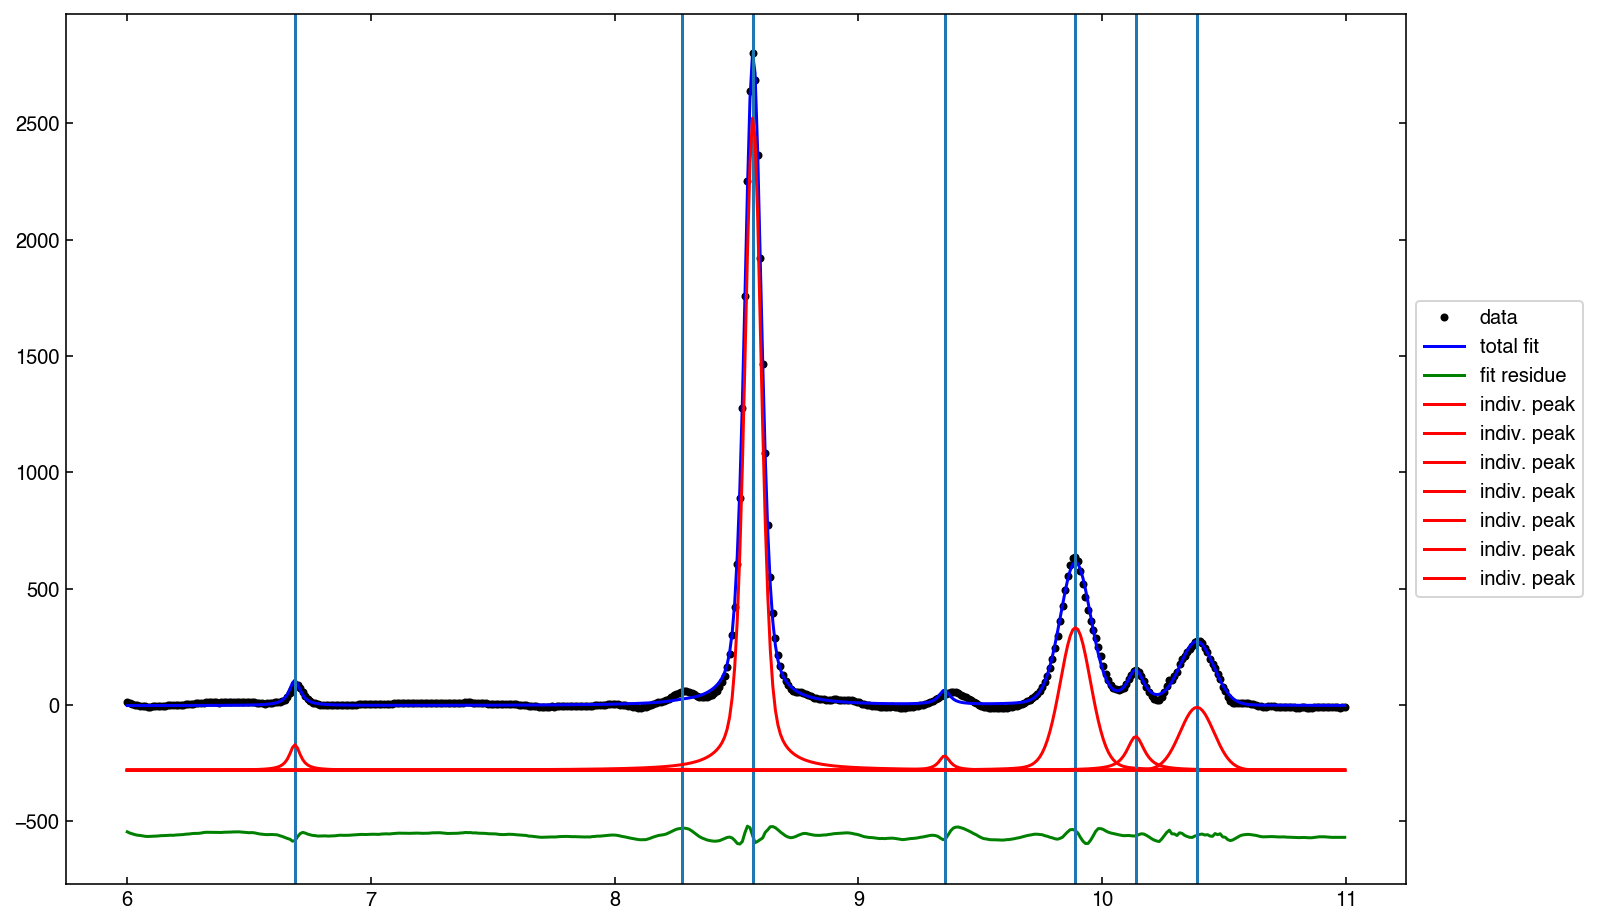

In [22]:
n_peaks = len(peak_positions_i)
figure, ax = plt.subplots(figsize=(12,8))
plot_fitresult(ax, x_ma, y_ma, out, n_peaks)

## Do better initial guess

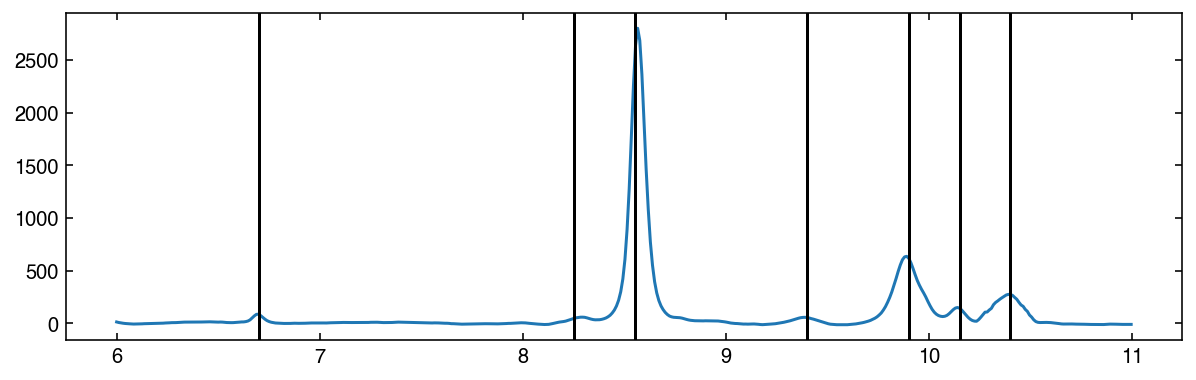

In [23]:
peak_positions_i = [6.7, 8.25, 8.55, 9.4, 9.9, 10.15, 10.4]

figure = plt.subplots(figsize=(10,3))
plt.plot(x_ma, y_ma)
for pkpo in peak_positions_i:
    plt.axvline(pkpo, c='k')

Pereform new fitting

In [24]:
mod, pars = make_model(peak_positions_i, fwhm=0.03, amplitude=500.)
out = mod.fit(y_ma, pars, x=x_ma, fit_kws={'maxfev': 500})
print(out.fit_report(min_correl=0.5))

[[Model]]
    (((((((Model(linear, prefix='bg_') + Model(pvoigt, prefix='pk0_')) + Model(pvoigt, prefix='pk1_')) + Model(pvoigt, prefix='pk2_')) + Model(pvoigt, prefix='pk3_')) + Model(pvoigt, prefix='pk4_')) + Model(pvoigt, prefix='pk5_')) + Model(pvoigt, prefix='pk6_'))
[[Fit Statistics]]
    # function evals   = 161
    # data points      = 1439
    # variables        = 30
    chi-square         = 135110.012
    reduced chi-square = 95.891
    Akaike info crit   = 6596.141
    Bayesian info crit = 6754.292
[[Variables]]
    bg_intercept:    0.22635949 +/- 0.774140 (342.00%) (init= 0)
    bg_slope:       -0.00496763 +/- 0.019437 (391.28%) (init= 0)
    pk0_fraction:    0.91122458 +/- 0.228407 (25.07%) (init= 0)
    pk0_sigma:       0.03125343 +/- 0.003824 (12.24%) (init= 0.03)
    pk0_center:      6.69474608 +/- 0.001993 (0.03%) (init= 6.7)
    pk0_amplitude:   8.28589108 +/- 0.828663 (10.00%) (init= 500)
    pk0_fwhm:        0.06250686 +/- 0.007648 (12.24%)  == '2.0000000*pk0_sigma'

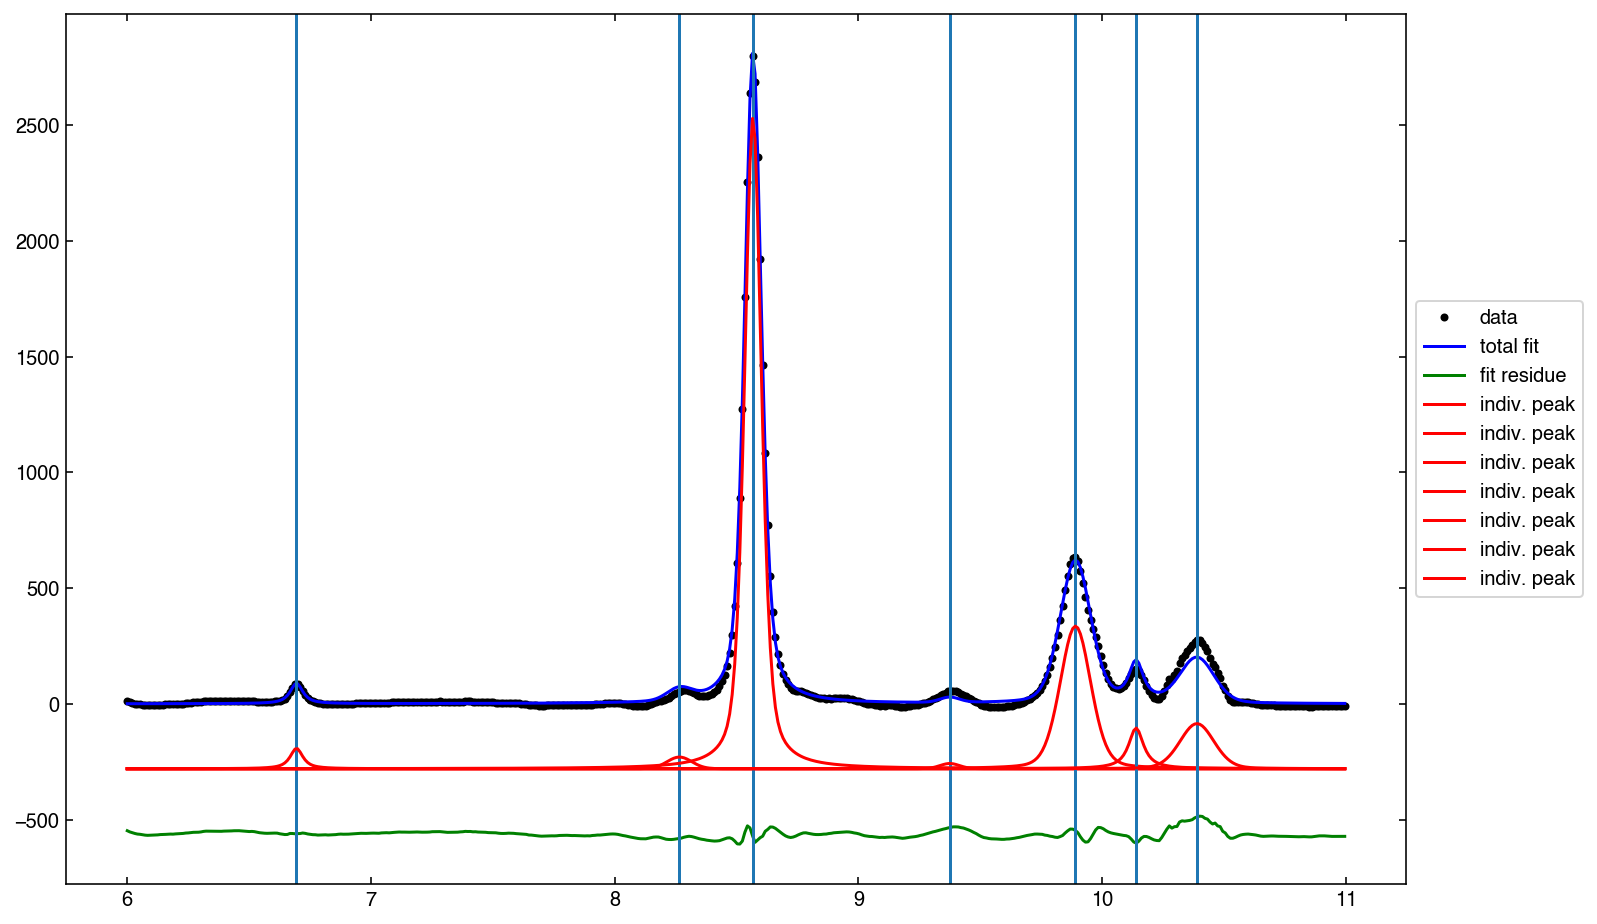

In [25]:
n_peaks = len(peak_positions_i)
figure, ax = plt.subplots(figsize=(12,8))
plot_fitresult(ax, x_ma, y_ma, out, n_peaks)

## Use the last fitting results for the next fitting

In [26]:
pars_new = out.params

In [27]:
out = mod.fit(y_ma, pars_new, x=x_ma, fit_kws={'maxfev': 500})
print(out.fit_report(min_correl=0.5))

[[Model]]
    (((((((Model(linear, prefix='bg_') + Model(pvoigt, prefix='pk0_')) + Model(pvoigt, prefix='pk1_')) + Model(pvoigt, prefix='pk2_')) + Model(pvoigt, prefix='pk3_')) + Model(pvoigt, prefix='pk4_')) + Model(pvoigt, prefix='pk5_')) + Model(pvoigt, prefix='pk6_'))
[[Fit Statistics]]
    # function evals   = 504
    # data points      = 1439
    # variables        = 30
    chi-square         = 56209.158
    reduced chi-square = 39.893
    Akaike info crit   = 5334.124
    Bayesian info crit = 5492.275
[[Variables]]
    bg_intercept:   -3.71700993 +/- 0.492281 (13.24%) (init= 0.2263595)
    bg_slope:       -0.00937877 +/- 0.012537 (133.68%) (init=-0.004967634)
    pk0_fraction:    0.99998977 +/- 0.135246 (13.52%) (init= 0.9112246)
    pk0_sigma:       0.03445374 +/- 0.003051 (8.86%) (init= 0.03125343)
    pk0_center:      6.69456772 +/- 0.001502 (0.02%) (init= 6.694746)
    pk0_amplitude:   9.72073550 +/- 0.564786 (5.81%) (init= 8.285891)
    pk0_fwhm:        0.06890749 +/- 0.006

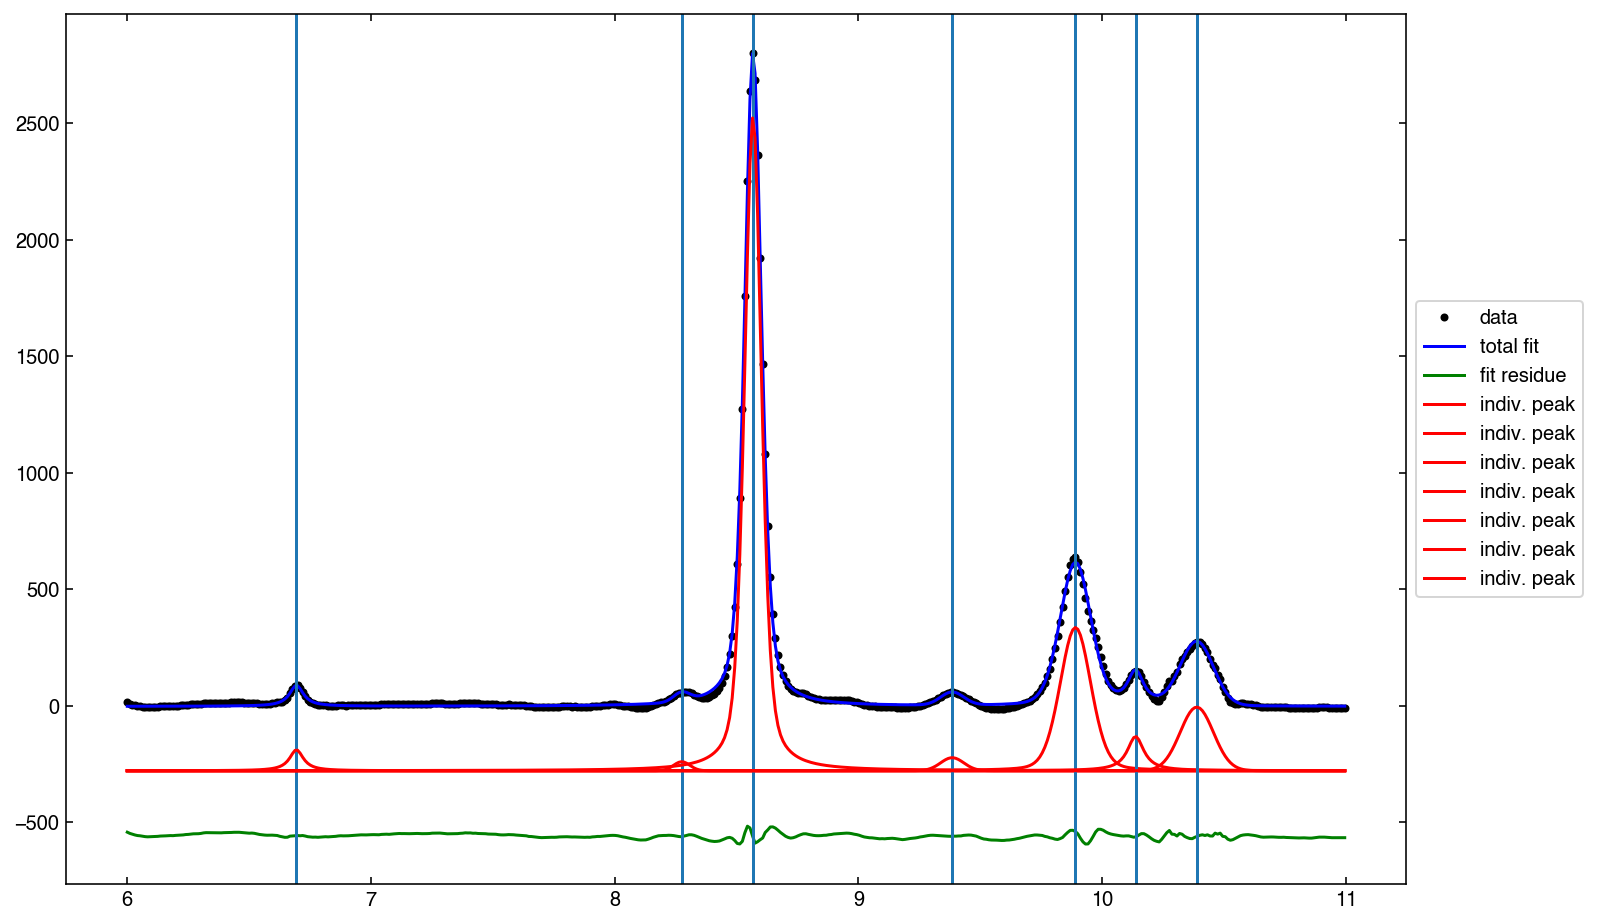

In [28]:
n_peaks = len(peak_positions_i)
figure, ax = plt.subplots(figsize=(12,8))
plot_fitresult(ax, x_ma, y_ma, out, n_peaks)

## Fix some parameters for fitting

In [29]:
pars_new = out.params
pars_new

Parameters([('bg_intercept',
             <Parameter 'bg_intercept', value=-3.7170099334033093 +/- 0.492, bounds=[-inf:inf]>),
            ('bg_slope',
             <Parameter 'bg_slope', value=-0.009378776278280536 +/- 0.0125, bounds=[-inf:inf]>),
            ('pk0_fraction',
             <Parameter 'pk0_fraction', value=0.9999897730225922 +/- 0.135, bounds=[0.0:1.0]>),
            ('pk0_sigma',
             <Parameter 'pk0_sigma', value=0.03445374803438142 +/- 0.00305, bounds=[0.0:0.5]>),
            ('pk0_center',
             <Parameter 'pk0_center', value=6.694567725034913 +/- 0.0015, bounds=[6.2:7.2]>),
            ('pk0_amplitude',
             <Parameter 'pk0_amplitude', value=9.720735508478093 +/- 0.565, bounds=[0.0:inf]>),
            ('pk0_fwhm',
             <Parameter 'pk0_fwhm', value=0.06890749606876284 +/- 0.0061, bounds=[-inf:inf], expr='2.0000000*pk0_sigma'>),
            ('pk1_fraction',
             <Parameter 'pk1_fraction', value=3.0743032736813e-05 +/- 0.0367, bo

In [30]:
pars_new['pk0_center'].set(6.4, vary=False)

In [31]:
out = mod.fit(y_ma, pars_new, x=x_ma, fit_kws={'maxfev': 500})
print(out.fit_report(min_correl=0.5))

[[Model]]
    (((((((Model(linear, prefix='bg_') + Model(pvoigt, prefix='pk0_')) + Model(pvoigt, prefix='pk1_')) + Model(pvoigt, prefix='pk2_')) + Model(pvoigt, prefix='pk3_')) + Model(pvoigt, prefix='pk4_')) + Model(pvoigt, prefix='pk5_')) + Model(pvoigt, prefix='pk6_'))
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 1439
    # variables        = 29
    chi-square         = 113567.760
    reduced chi-square = 80.545
    Akaike info crit   = 6344.201
    Bayesian info crit = 6497.081
[[Variables]]
    bg_intercept:   -3.71701024 +/- 0.691347 (18.60%) (init=-3.71701)
    bg_slope:       -0.00937870 +/- 0.017815 (189.95%) (init=-0.009378776)
    pk0_fraction:    0.99993979 +/- 0.209576 (20.96%) (init= 0.9999898)
    pk0_sigma:       0.03445533 +/- 0.004336 (12.59%) (init= 0.03445375)
    pk0_center:      6.4 (fixed)
    pk0_amplitude:   9.72041756 +/- 0.797996 (8.21%) (init= 9.720736)
    pk0_fwhm:        0.06891066 +/- 0.008673 (12.59%)  == '2.0000000*pk0_sigma'

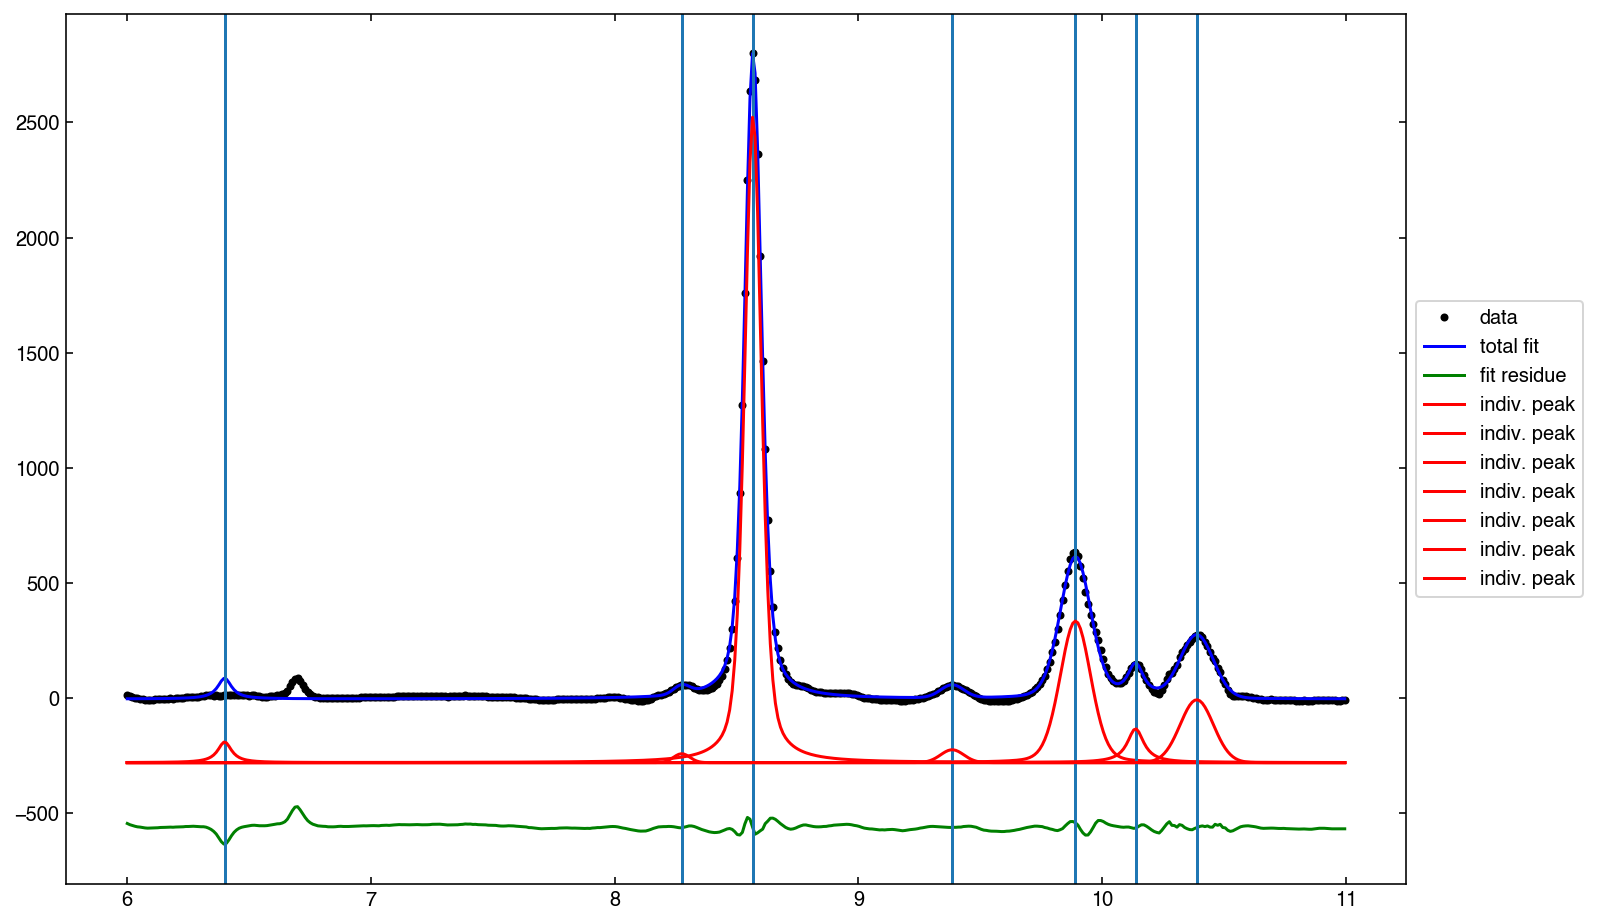

In [32]:
n_peaks = len(peak_positions_i)
figure, ax = plt.subplots(figsize=(12,8))
plot_fitresult(ax, x_ma, y_ma, out, n_peaks)